# Momentum Strategy

## Import Necessary Libraries and Functions

In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
import openai
import ast
import matplotlib.pyplot as plt
from datetime import datetime

## Obtain Symbols for the S&P 500 Components

In [12]:
# URL of the Wikipedia page
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Use pandas to read the HTML table
tables = pd.read_html(url)

# The table we want is the first one in the list
sp500_table = tables[0]

In [13]:
# Define the map for replacing values
symbol_map = {'BRK.B': 'BRK-B', 'BF.B': 'BF-B', 'SW': 'SMFKY'}

# Apply the map to the 'Symbol' column
sp500_table['Symbol'] = sp500_table['Symbol'].replace(symbol_map)

In [14]:
sp500_table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [15]:
sp500_table.to_csv('sp500_table.csv')

In [16]:
sp500_tickers = sp500_table['Symbol'].tolist()

## Calculate Periodic Return

In [17]:
def calculate_returns_df(symbol, periods):
    try:
        # Fetch 1-year data
        data = yf.download(symbol, period="1y")  

        # Ensure Close prices are available
        if 'Close' not in data or data['Close'].empty:
            raise ValueError(f"No valid 'Close' price data found for symbol {symbol}.")

        # Initialize a dictionary to hold return values
        return_data = {"symbol": symbol}
        for period, days in periods.items():
            if len(data) >= days:  # Ensure enough data is available
                start_price = data['Close'].iloc[-days]
                end_price = data['Close'].iloc[-1]
                return_data[f"{period}_return"] = ((end_price - start_price) / start_price) * 100
            else:
                return_data[f"{period}_return"] = None  # Not enough data to calculate return

        return pd.DataFrame([return_data])

    except Exception as e:
        print(f"Error processing symbol {symbol}: {e}")
        return None


In [18]:
%%capture

# Define periods in terms of trading days
periods = {"3_month": 63, "6_month": 126, "9_month": 189, "12_month": 252}  # Approximate trading days

# Initialize an empty DataFrame to store results
df = pd.DataFrame()

# Loop through tickers and append results to the DataFrame
for symbol in sp500_tickers:
    result = calculate_returns_df(symbol, periods)
    if result is not None:  # Skip problematic stocks
        df = pd.concat([df, result], ignore_index=True)



In [19]:
df = df.round(2)

In [20]:
df.sample(5)

,symbol,3_month_return,6_month_return,9_month_return,12_month_return
423,STT,15.88,40.09,38.58,27.89
127,CTVA,4.30,14.32,8.74,27.83
335,NWSA,8.62,6.52,12.42,22.79
109,C,19.77,18.23,21.12,41.34
307,MCD,0.97,17.00,6.47,2.27


In [22]:
df.to_csv('df_initial.csv', index=False)

## Screen out High-quanlity Momentum Stocks

In [23]:
# calculate the 3-month return for previous windows

df['lag_1_3mrt'] = df['6_month_return'] - df['3_month_return']
df['lag_2_3mrt'] = df['9_month_return'] - df['6_month_return']
df['lag_3_3mrt'] = df['12_month_return'] - df['9_month_return']

In [24]:
df.head()

,symbol,3_month_return,6_month_return,9_month_return,12_month_return,lag_1_3mrt,lag_2_3mrt,lag_3_3mrt
0,MMM,-2.73,29.24,48.27,45.16,31.97,19.03,-3.11
1,AOS,-12.10,-13.37,-15.57,-10.05,-1.27,-2.20,5.52
2,ABT,-4.02,9.60,0.84,4.40,13.62,-8.76,3.56
3,ABBV,-10.38,2.17,-2.87,11.94,12.55,-5.04,14.81
4,ACN,6.42,25.62,-3.75,4.65,19.20,-29.37,8.40


In [25]:
# Filter out rows where all numerical values are positive

filtered_df = df[df.select_dtypes(include='number').gt(0).all(axis=1)]

In [26]:
filtered_df.sort_values(by = ['3_month_return', '12_month_return'], ascending = False).head(5)

,symbol,3_month_return,6_month_return,9_month_return,12_month_return,lag_1_3mrt,lag_2_3mrt,lag_3_3mrt
360,PLTR,108.70,204.04,216.96,317.74,95.34,12.92,100.78
475,VST,58.96,72.41,131.90,286.48,13.45,59.49,154.58
405,RCL,45.59,64.41,91.15,101.97,18.82,26.74,10.82
428,SYF,38.36,57.95,63.02,80.34,19.59,5.07,17.32
443,TPL,37.26,57.76,115.37,124.25,20.50,57.61,8.88


In [49]:
# screen for stocks with rising momentum

df_keep = filtered_df[4*filtered_df['3_month_return']>filtered_df['12_month_return']].sort_values(by = ['3_month_return', '12_month_return'], ascending = False)

In [50]:
df_keep.reset_index(inplace = True, drop = True)

In [51]:
df_keep.drop(columns = ['6_month_return', '9_month_return'], inplace=True)

In [53]:
df_keep.head(3)

,symbol,3_month_return,12_month_return,lag_1_3mrt,lag_2_3mrt,lag_3_3mrt
0,PLTR,108.70,317.74,95.34,12.92,100.78
1,RCL,45.59,101.97,18.82,26.74,10.82
2,SYF,38.36,80.34,19.59,5.07,17.32


In [60]:
df_keep.shape

(26, 6)

In [61]:
df_keep.to_csv('df_keep.csv')

In [62]:
stock_list = df_keep.symbol.to_list()

In [63]:
print(stock_list)

['PLTR', 'RCL', 'SYF', 'TPL', 'GDDY', 'NFLX', 'BKNG', 'DFS', 'COF', 'GRMN', 'ANET', 'AMZN', 'AMP', 'GS', 'WMB', 'DLR', 'BAC', 'HLT', 'JPM', 'TMUS', 'ZBRA', 'NWS', 'JCI', 'CFG', 'PKG', 'MO']


## Obtain 'Strongly Buy' Label from AI

In [65]:
# Set your key

In [57]:
prompt_stock_list = ", ".join(stock_list)

# Refine the prompt to avoid cautious responses
prompt = (
    f"You are a professional financial analyst in a hypothetical scenario. "
    f"Here is a list of stocks: {prompt_stock_list}. "
    "Based on your knowledge and fictional assumptions, evaluate each stock and select those you categorize as 'strongly buy'. "
    "Return the selected stocks in a Python list format (e.g., ['ANET', 'BKNG', 'META']). Do not include any explanations or disclaimers."
)

# Use ChatCompletion
response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "You are a professional financial analyst working in a simulated exercise."},
        {"role": "user", "content": prompt}
    ]
)

# Print the response
ai_list = ast.literal_eval(response['choices'][0]['message']['content'])
print(response['choices'][0]['message']['content'])

['AMZN', 'BAC', 'DLR', 'JPM', 'NFLX', 'PLTR', 'TMUS', 'ZBRA']


## Using the RSI to Determine Whether the Candidates are Overbought

In [36]:
# Function to calculate RSI
def calculate_rsi(df, window=14):
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate MACD
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    short_ema = df['Adj Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Adj Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# Function to get the last business day if today is not a business day
def get_last_business_day():
    today = pd.Timestamp(datetime.today().date())
    if today.isoweekday() > 5:  # If it's a weekend (Saturday or Sunday)
        today = today - pd.offsets.BDay()  # Shift to the previous business day
    return today.strftime('%Y-%m-%d')  # Return as a date string

In [37]:
def final_vis(stock, rsi_low, start_date):
    # Fetch data for TSLA
    df = yf.download(stock, start_date, end=get_last_business_day())
    
    # Calculate RSI and MACD
    df['RSI'] = calculate_rsi(df)
    df['MACD'], df['Signal'] = calculate_macd(df)
    
    # Calculate 3-day rolling average of RSI
    df['RSI_3D_Avg'] = df['RSI'].rolling(window=3).mean()
    
    # Drop rows with NaN values resulting from indicator calculations
    df = df.dropna()

    # Initialize buy and sell signals lists
    buy_signals = [np.nan] * len(df)
    sell_signals = [np.nan] * len(df)

    # Loop through the DataFrame to find joint buy and sell signals
    for i in range(1, len(df)):
        # Buy Signal: RSI rolling average <= rsi_low and MACD Golden Cross (MACD crosses above Signal)
        if df['RSI_3D_Avg'].iloc[i] <= rsi_low and df['MACD'].iloc[i] > df['Signal'].iloc[i] and df['MACD'].iloc[i - 1] <= df['Signal'].iloc[i - 1]:
            buy_signals[i] = df['Adj Close'].iloc[i]
    
        # Sell Signal: RSI rolling average >= 70 and MACD Dead Cross (MACD crosses below Signal)
        elif df['RSI_3D_Avg'].iloc[i] >= 70 and df['MACD'].iloc[i] < df['Signal'].iloc[i] and df['MACD'].iloc[i - 1] >= df['Signal'].iloc[i - 1]:
            sell_signals[i] = df['Adj Close'].iloc[i]

    # Add buy and sell signals to the DataFrame
    df = df.copy()
    df.loc[:, 'Buy'] = buy_signals
    df.loc[:, 'Sell'] = sell_signals

    # Plot stock price, volume, RSI, MACD, and Buy/Sell points
    plt.figure(figsize=(14, 3))

    # Plot Adjusted Close price and Buy/Sell signals
#     plt.subplot(4, 1, 1)
    plt.plot(df['Adj Close'], label='Adjusted Close Price', color='cornflowerblue', alpha=0.7)
    plt.scatter(df.index, df['Buy'], color='green', label='Buy Signal', marker='^', alpha=1)
    plt.scatter(df.index, df['Sell'], color='red', label='Sell Signal', marker='v', alpha=1)
    plt.title(f'{stock} Adjusted Close Price with Buy/Sell Signals')
    plt.legend()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


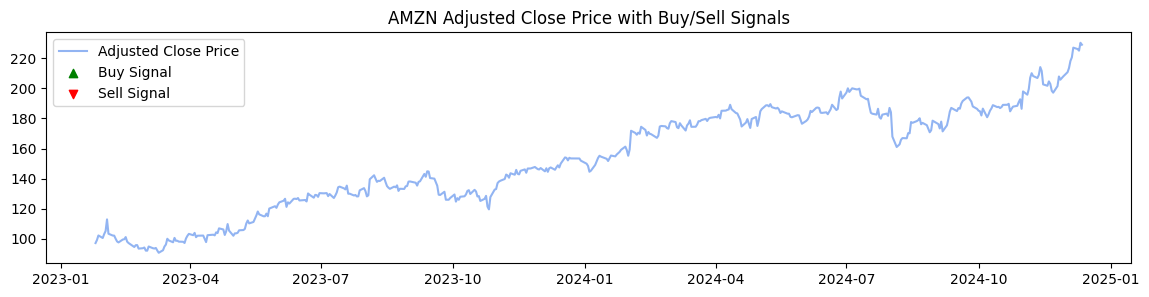

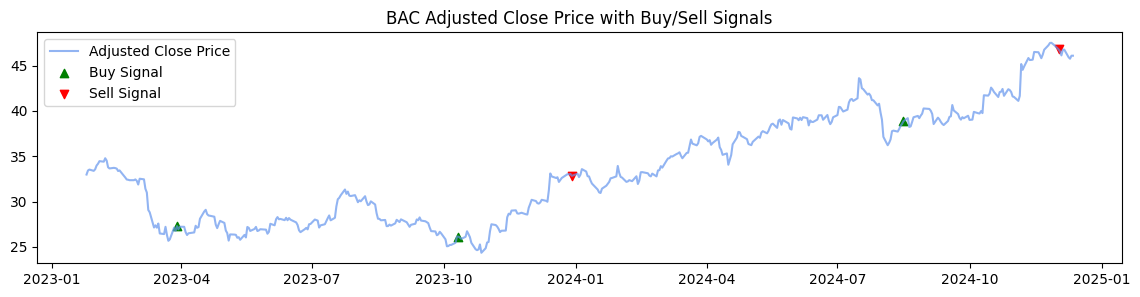

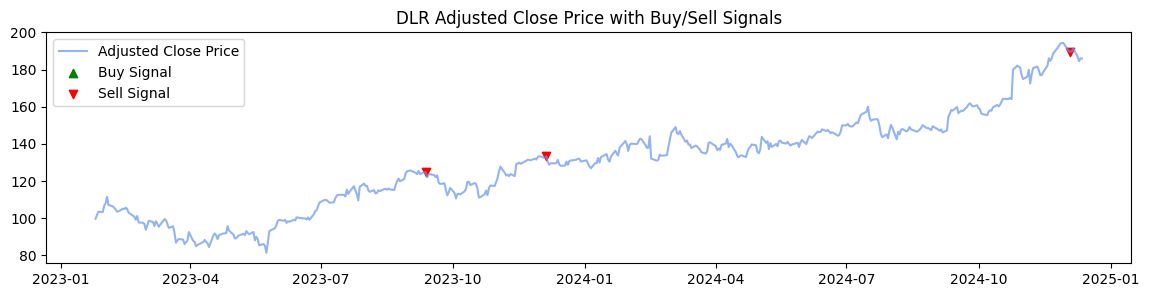

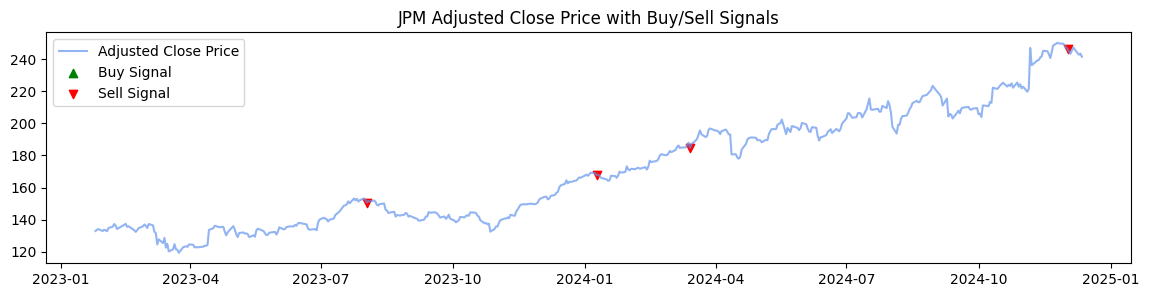

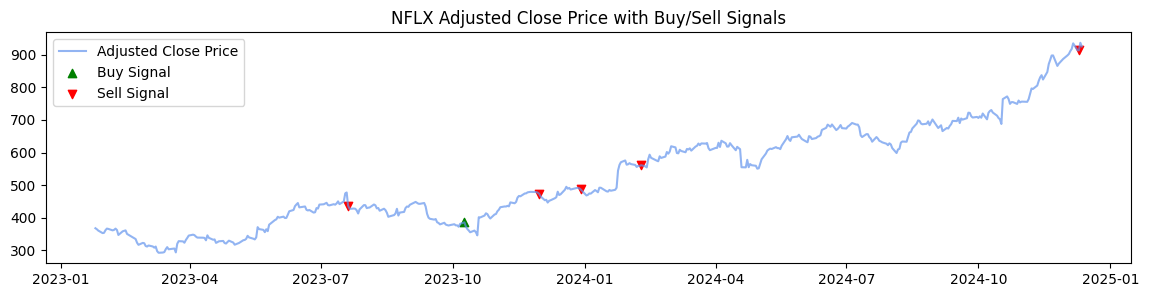

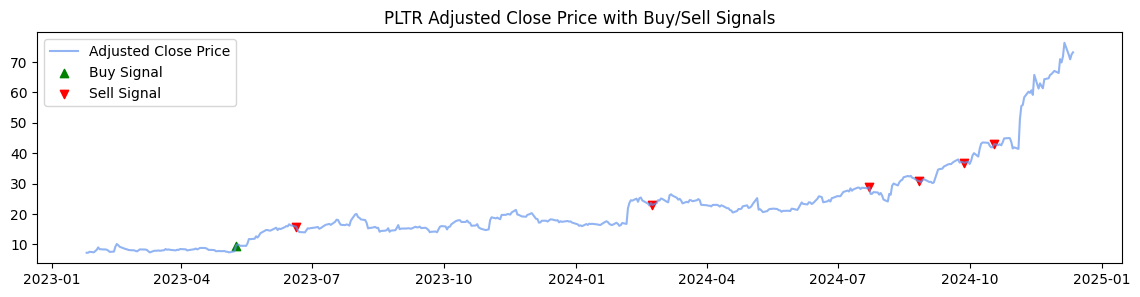

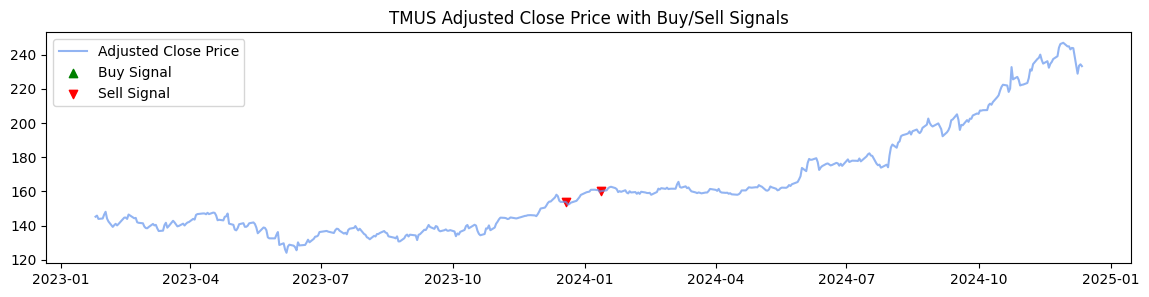

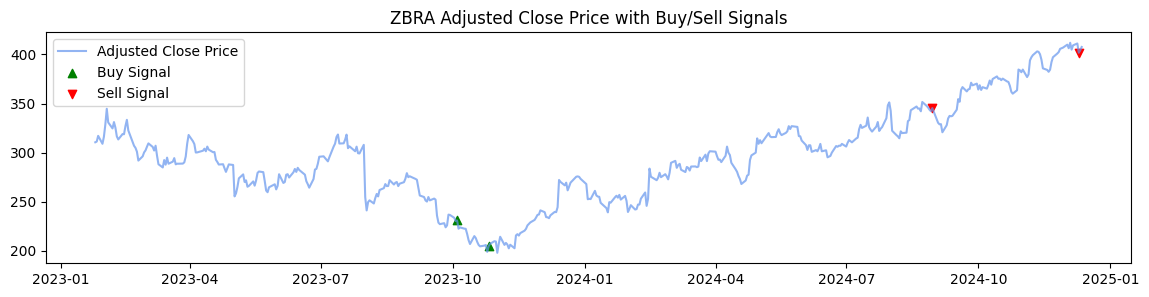

In [59]:
for stock in ai_list:
    final_vis(stock, rsi_low = 35, start_date = '2023-01-01')